In [60]:
import pandas as pd
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Import Data

In [224]:
train = pd.read_csv('/Users/dylanhayashi/Desktop/MSDS 422 - Practical Machine Learning/Data/allstate-claims-severity/train.csv')
test = pd.read_csv('/Users/dylanhayashi/Desktop/MSDS 422 - Practical Machine Learning/Data/allstate-claims-severity/test.csv')

In [225]:
display(train.info(), train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


None

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


### Missing Data

In [226]:
# Training Data
print(f'\nNumber of missing values in the training set: {train.isnull().sum().sum()}\nWonderful!')

# Test Data
print(f'\nNumber of missing values in the test set: {test.isnull().sum().sum()}\nWonderful!')


Number of missing values in the training set: 0
Wonderful!

Number of missing values in the test set: 0
Wonderful!


### Target Variable: Loss

Loss Skew : 3.795
Loss Kurtosis : 48.08


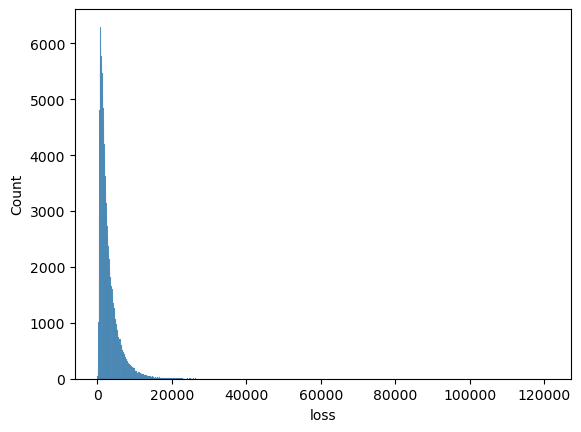

In [227]:
# Skew / Kurtosis
loss = train.loc[:,'loss']
loss_skew = loss.skew()
loss_kurtosis = loss.kurtosis()
print(f'Loss Skew : {round(loss_skew,3)}')
print(f'Loss Kurtosis : {round(loss_kurtosis,3)}')

# Distplot
loss_histplot = sns.histplot(loss)
plt.show(loss_histplot)

Loss is highly skewed and has high kurtosis.
Log transformation of loss improves that.

Log Loss Skew : 0.093
Log Loss Kurtosis : -0.115


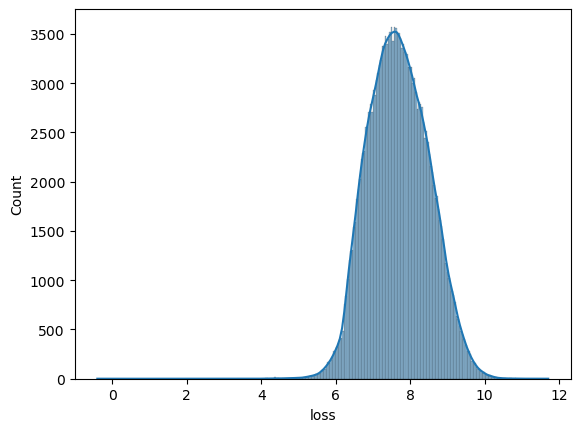

In [228]:
# Log Loss
print('Loss is highly skewed and has high kurtosis.')
print('Log transformation of loss improves that.')


# Skew / Kurtosis
log_loss = np.log(loss)
log_loss_skew = log_loss.skew()
log_loss_kurtosis = log_loss.kurtosis()
print(f'\nLog Loss Skew : {round(log_loss_skew,3)}')
print(f'Log Loss Kurtosis : {round(log_loss_kurtosis,3)}')

# Distplot
log_loss_histplot = sns.histplot(log_loss, kde = True)
plt.show(log_loss_histplot)

# Transformation
# Log Loss Transformation
train['log_loss'] = np.log(train['loss'])

### Outliers

In [302]:
# Outliers

# Calculate range
mean = train['log_loss'].mean()
std_dev = train['log_loss'].std()
lower_limit = mean - (3 * std_dev)
upper_limit = mean + (3 * std_dev)

# Subset outliers
positive_outliers = train[train['log_loss'] > upper_limit]
negative_outliers = train[train['log_loss'] < lower_limit]

# Count Outliers
print(f'There are {len(positive_outliers)} positive outliers and {len(negative_outliers)} negative outliers.')
print('I will be dropping all outliers.\n')

x_train = train[train['log_loss'] < upper_limit]
x_train = x_train[x_train['log_loss'] > lower_limit]

x_train = x_train.reset_index().drop(['index','id','loss'], axis = 1)
y_train = x_train.loc[:,'log_loss']

print('The current state of x_train:')
display(x_train.head())

There are 166 positive outliers and 198 negative outliers.
I will be dropping all outliers.

The current state of x_train:


,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,log_loss
0,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,7.702186
1,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,7.157424
2,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,8.008063
3,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,6.845720
4,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,7.924380


### Continuous Variables

In [303]:
# Create continuous variable subset
continuous_variables = x_train.loc[:,x_train.columns[-15:-1]] 
display(continuous_variables.head())

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843
1,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496
2,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425
3,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642
4,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606


In [304]:
# Correlations
corr_table = pd.DataFrame(columns = ['variable','corr'])

# Analyze variable correlation with loss
for each_variable in continuous_variables.columns:
    variable = continuous_variables.loc[:,each_variable]
    corr = round(variable.corr(y_train),3)
    var_row = pd.DataFrame({'variable' : [each_variable], 'corr':[corr]})
    corr_table = corr_table.append(var_row)
    corr_table = corr_table.sort_values(['corr'], ascending = False)

print('I will be using the 10 highest correlated continuous variables.')
display(corr_table[0:10])

I will be using the 10 highest correlated continuous variables.


,variable,corr
0,cont2,0.103
0,cont7,0.080
0,cont3,0.079
0,cont11,0.069
0,cont12,0.068
0,cont8,0.032
0,cont6,0.029
0,cont14,0.025
0,cont9,0.017
0,cont10,0.009



cont11 and cont12 look to be nearly perfectly correlated, I will drop cont12.


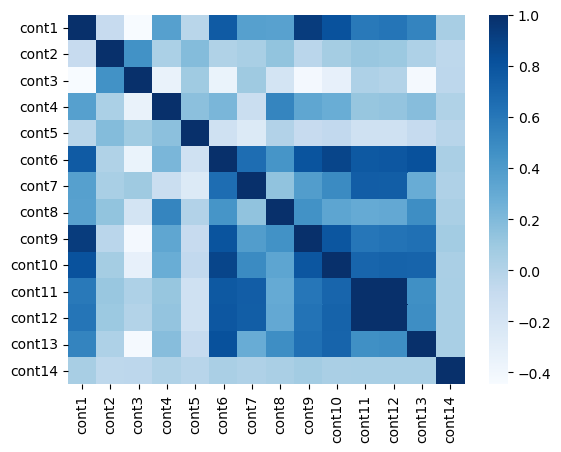

In [305]:
# Multi-Collinearity
sns.heatmap(continuous_variables.corr(), cmap="Blues")

print('\ncont11 and cont12 look to be nearly perfectly correlated, I will drop cont12.')
x_train_cont = continuous_variables.drop(['cont12'], axis = 1)
plt.show()

In [254]:
# Create final subset
x_train_cont = pd.DataFrame()
for each_column in corr_table.loc[:,'variable'][0:10]:
    column = continuous_variables.loc[:,each_column]
    x_train_cont[each_column] = column
print('This is the continuous variable subset of my training set.')
display(x_train_cont.head())

This is the continuous variable subset of my training set.


,cont2,cont7,cont3,cont11,cont12,cont8,cont6,cont14,cont9,cont10
0,0.245921,0.335060,0.187583,0.569745,0.594646,0.30260,0.718367,0.714843,0.67135,0.83510
1,0.737068,0.436585,0.592681,0.338312,0.366307,0.60087,0.438917,0.304496,0.35127,0.43919
2,0.358319,0.315545,0.484196,0.381398,0.373424,0.27320,0.289648,0.774425,0.26076,0.32446
3,0.555782,0.391128,0.527991,0.327915,0.321570,0.31796,0.440945,0.602642,0.32128,0.44467
4,0.159990,0.247408,0.527991,0.204687,0.202213,0.24564,0.178193,0.432606,0.22089,0.21230


### Categorical Variables

In [262]:
# Create categorical variable subset
categorical_variables = x_train[x_train.columns[1:-15]]
display(categorical_variables.head())

,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,B,A,B,A,A,A,A,B,A,B,...,J,G,BU,BC,C,AS,S,A,O,LB
1,B,A,A,A,A,A,A,B,B,A,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,B,A,A,B,A,A,A,B,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,A,B,A,A,A,A,B,A,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,B,A,B,A,A,A,A,B,B,A,...,G,B,H,C,C,Y,BM,A,K,CK


In [263]:
# Encode by setting equal to median loss of group that shares categorical valuable value

x_train_cat = categorical_variables.copy(deep = True)

x_train_cat['log_loss_scaled'] = y_train.copy(deep = True)

for column in x_train_cat.columns[:-1]:
    alpha_values = pd.DataFrame()
    alpha_values[column] = x_train_cat.loc[:,column]
    median_values_per_class = pd.DataFrame(x_train_cat['log_loss_scaled'].groupby(x_train_cat[column]).median())
    encoded_values = alpha_values.merge(median_values_per_class, how = 'left', on = column).loc[:,'log_loss_scaled']
    x_train_cat[column] = encoded_values
    
x_train_cat = x_train_cat.drop('log_loss_scaled', axis = 1)

display(x_train_cat.head(5))

,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,7.948096,7.617853,7.806985,7.574533,7.758711,7.637447,7.635893,7.956104,7.551649,8.279761,...,7.651011,7.708231,7.628834,7.572848,7.633437,7.804969,7.602366,7.758711,7.639597,7.671179
1,7.948096,7.617853,7.588526,7.574533,7.758711,7.637447,7.635893,7.956104,8.313906,7.585926,...,7.620261,7.621925,7.668972,7.597923,7.588526,7.379445,7.616141,7.758711,7.639597,7.645627
2,7.948096,7.617853,7.588526,7.809527,7.758711,7.637447,7.635893,7.956104,8.313906,8.279761,...,7.649107,7.692198,7.625861,7.613330,7.588526,7.687947,7.671766,7.758711,7.611328,7.626305
3,7.948096,7.617853,7.806985,7.574533,7.758711,7.637447,7.635893,7.956104,7.551649,7.585926,...,7.620261,7.621925,7.668972,7.629067,7.633437,7.667481,7.623732,7.758711,7.639597,7.617381
4,7.948096,7.617853,7.806985,7.574533,7.758711,7.637447,7.635893,7.956104,8.313906,7.585926,...,7.711961,7.622351,7.583451,7.589902,7.633437,7.633955,7.616141,7.758711,7.649745,7.702872


In [264]:
corr_table = pd.DataFrame(columns = ['variable','corr'])
for each_variable in x_train_cat.columns:
    variable = x_train_cat.loc[:,each_variable]
    corr = round(variable.corr(y_train),3)
    var_row = pd.DataFrame({'variable' : [each_variable], 'corr':[corr]})
    corr_table = corr_table.append(var_row)
    corr_table = corr_table.sort_values(['corr'], ascending = False)
    
print('I will be using the 10 most highly correlated categorical variables.')
display(corr_table[0:10])

I will be using the 10 most highly correlated categorical variables.


,variable,corr
0,cat80,0.489
0,cat79,0.419
0,cat101,0.383
0,cat100,0.370
0,cat87,0.340
0,cat12,0.337
0,cat10,0.299
0,cat81,0.294
0,cat2,0.263
0,cat114,0.251


In [300]:
# Create x_train categorical variables by subsetting 
x_train_cat_filtered = pd.DataFrame()

for each_column in corr_table.loc[:,'variable'][0:10]:
    column = x_train_cat.loc[:,each_column]
    x_train_cat_filtered[each_column] = column

x_train_cat_filtered.head()

,cat80,cat79,cat101,cat100,cat87,cat12,cat10,cat81,cat2,cat114
0,7.436697,7.528730,7.879991,7.745513,7.568320,7.534001,7.551649,7.544591,7.948096,7.758711
1,7.436697,7.528730,7.908501,8.106107,7.568320,7.534001,8.313906,7.544591,7.948096,7.758711
2,8.425146,7.528730,8.691905,8.106107,7.568320,8.368223,8.313906,7.544591,7.948096,7.758711
3,7.436697,7.528730,7.564218,7.295213,7.568320,7.534001,7.551649,7.544591,7.948096,7.758711
4,8.425146,8.597416,8.247291,7.751090,8.507282,8.368223,8.313906,7.544591,7.948096,7.758711


In [301]:
# Create x_train categorical variables by subsetting 

# Mix / Max Scaling
min_max_scaler = MinMaxScaler()
x_train_cat_scaled = pd.DataFrame(min_max_scaler.fit_transform(x_train_cat_filtered))
x_train_cat_scaled.columns = x_train_cat_filtered.columns
print('This is the categorical variable subset of my training set.')

display(x_train_cat_scaled.head())

This is the categorical variable subset of my training set.


,cat80,cat79,cat101,cat100,cat87,cat12,cat10,cat81,cat2,cat114
0,0.116207,0.0,0.365818,0.540169,0.207750,0.0,0.0,0.250418,1.0,0.356412
1,0.116207,0.0,0.375870,0.870836,0.207750,0.0,1.0,0.250418,1.0,0.356412
2,1.000000,0.0,0.652091,0.870836,0.207750,1.0,1.0,0.250418,1.0,0.356412
3,0.116207,0.0,0.254478,0.127240,0.207750,0.0,0.0,0.250418,1.0,0.356412
4,1.000000,1.0,0.495324,0.545283,0.952262,1.0,1.0,0.250418,1.0,0.356412


In [269]:
# Concatenate Contiuous and Categorical Subsets to Create Final Training Set
x_train_final = pd.concat([x_train_cat_scaled, x_train_cont], axis = 'columns')
x_train_final['log_loss_scaled'] = y_train
display(x_train_final.head())

,cat80,cat79,cat101,cat100,cat87,cat12,cat10,cat81,cat2,cat114,...,cont7,cont3,cont11,cont12,cont8,cont6,cont14,cont9,cont10,log_loss_scaled
0,0.116207,0.0,0.365818,0.540169,0.207750,0.0,0.0,0.250418,1.0,0.356412,...,0.335060,0.187583,0.569745,0.594646,0.30260,0.718367,0.714843,0.67135,0.83510,7.702186
1,0.116207,0.0,0.375870,0.870836,0.207750,0.0,1.0,0.250418,1.0,0.356412,...,0.436585,0.592681,0.338312,0.366307,0.60087,0.438917,0.304496,0.35127,0.43919,7.157424
2,1.000000,0.0,0.652091,0.870836,0.207750,1.0,1.0,0.250418,1.0,0.356412,...,0.315545,0.484196,0.381398,0.373424,0.27320,0.289648,0.774425,0.26076,0.32446,8.008063
3,0.116207,0.0,0.254478,0.127240,0.207750,0.0,0.0,0.250418,1.0,0.356412,...,0.391128,0.527991,0.327915,0.321570,0.31796,0.440945,0.602642,0.32128,0.44467,6.845720
4,1.000000,1.0,0.495324,0.545283,0.952262,1.0,1.0,0.250418,1.0,0.356412,...,0.247408,0.527991,0.204687,0.202213,0.24564,0.178193,0.432606,0.22089,0.21230,7.924380


### Cross Validation Sets

In [270]:
# Training Set Separation for Cross Validation
x_train, x_validate = train_test_split(x_train_final)
y_train = x_train.loc[:,'log_loss_scaled']
y_validate = x_validate.loc[:,'log_loss_scaled']

print('This is the training set.')
x_train = x_train.drop('log_loss_scaled', axis = 1)
display(x_train.head())

print('This is the validation set.')
x_validate = x_validate.drop('log_loss_scaled', axis = 1)
display(x_validate.head())

This is the training set.


,cat80,cat79,cat101,cat100,cat87,cat12,cat10,cat81,cat2,cat114,cont2,cont7,cont3,cont11,cont12,cont8,cont6,cont14,cont9,cont10
41611,0.116207,0.0,0.218609,0.337448,0.20775,0.0,0.0,0.250418,0.0,0.058710,0.620805,0.390775,0.527991,0.327915,0.321570,0.58934,0.383737,0.384680,0.35127,0.43919
86711,0.116207,0.0,0.218609,0.337448,0.20775,0.0,0.0,0.250418,0.0,0.058710,0.555782,0.528869,0.692825,0.705501,0.692256,0.54236,0.439206,0.810851,0.47900,0.51111
122917,0.116207,0.0,0.251592,1.000000,0.20775,0.0,0.0,0.250418,1.0,0.435365,0.827585,0.376887,0.549770,0.341813,0.352251,0.58354,0.350956,0.774482,0.44352,0.39599
111020,0.116207,0.0,0.218609,0.127240,0.20775,0.0,0.0,0.250418,0.0,0.232219,0.827585,0.310578,0.777587,0.260140,0.264760,0.25461,0.227020,0.349454,0.38249,0.35434
94027,0.116207,0.0,0.218609,0.337448,0.20775,0.0,0.0,0.250418,0.0,0.053923,0.358319,0.555446,0.745801,0.678924,0.729856,0.27797,0.393798,0.362299,0.50420,0.31003


This is the validation set.


,cat80,cat79,cat101,cat100,cat87,cat12,cat10,cat81,cat2,cat114,cont2,cont7,cont3,cont11,cont12,cont8,cont6,cont14,cont9,cont10
183742,0.116207,0.0,0.365818,0.545283,0.20775,1.0,0.0,0.250418,1.0,0.356412,0.488789,0.386554,0.215772,0.492200,0.481306,0.26847,0.404232,0.740497,0.39849,0.57172
96868,0.116207,0.0,0.495324,0.127240,0.20775,1.0,1.0,0.250418,1.0,0.356412,0.555782,0.350175,0.527991,0.327915,0.321570,0.26847,0.336105,0.235475,0.41471,0.44467
38514,0.116207,0.0,0.561404,0.540169,0.20775,1.0,0.0,0.250418,1.0,0.356412,0.620805,0.271616,0.419161,0.396226,0.387819,0.92347,0.384572,0.347385,0.48530,0.24766
153559,1.000000,1.0,0.495324,0.870836,1.00000,1.0,1.0,0.250418,1.0,0.356412,0.488789,0.381883,0.549770,0.341813,0.352251,0.58354,0.304628,0.598847,0.46226,0.38016
37242,1.000000,1.0,0.493639,1.000000,0.20775,1.0,1.0,0.250418,1.0,0.356412,0.299102,0.326973,0.187583,0.288058,0.282971,0.48266,0.387359,0.367319,0.75974,0.32935


### Test Set Pre-Processing & Transformation

In [298]:
# Continuous Variables Subset
# Create Subset
x_test_cont = test.loc[:,test.columns[-13:]]
x_test_cont = x_test_cont.loc[:,x_train_cont.columns]


# Categorical Variables Subset
# Create Subset 
x_test_cat = test.loc[:,test.columns[0:-14]]
x_test_cat = x_test_cat.loc[:,x_train_cat_filtered.columns]

x_test_cat.head()

,cat80,cat79,cat101,cat100,cat87,cat12,cat10,cat81,cat2,cat114
0,D,B,G,H,B,A,A,D,B,A
1,D,B,D,B,B,A,A,D,B,A
2,B,B,Q,G,B,B,B,B,B,A
3,B,D,A,G,D,A,A,D,A,A
4,D,B,A,A,B,A,A,D,A,C


In [299]:
# Encode as median log loss scaled value 
for column in x_test_cat.columns:
    variable = pd.DataFrame(x_test_cat.loc[:,column])
    medians = pd.DataFrame(train['log_loss'].groupby(train[column]).median())
    encoded_values = variable.merge(medians, how = 'left', on = column)
    x_test_cat[column] = encoded_values['log_loss']
    
x_test_cat.head()

,cat80,cat79,cat101,cat100,cat87,cat12,cat10,cat81,cat2,cat114
0,7.435786,7.527708,7.880094,7.983582,7.567640,7.533400,7.551024,7.543925,7.949441,7.758701
1,7.435786,7.527708,7.564218,7.745224,7.567640,7.533400,7.551024,7.543925,7.949441,7.758701
2,8.426868,7.527708,8.702262,8.198653,7.567640,8.371504,8.316097,8.260201,7.949441,7.758701
3,8.426868,8.601683,7.461209,8.198653,8.569808,7.533400,7.551024,7.543925,7.461209,7.758701
4,7.435786,7.527708,7.461209,7.156126,7.567640,7.533400,7.551024,7.543925,7.461209,7.186038


In [283]:
# Min Max Scale
scaler = MinMaxScaler()
x_test_cat = pd.DataFrame(scaler.fit_transform(x_test_cat))

# Concatenate continuous and categorical parts
x_test = pd.concat([x_test_cat, x_test_cont], axis = 'columns')
x_test.columns = x_train.columns
print('This is my test set.')
display(x_test.head())

This is my test set.


,cat80,cat79,cat101,cat100,cat87,cat12,cat10,cat81,cat2,cat114,cont2,cont7,cont3,cont11,cont12,cont8,cont6,cont14,cont9,cont10
0,0.115546,0.0,0.476160,0.757297,0.208024,0.0,0.0,0.250596,1.0,0.355135,0.299102,0.317681,0.246911,0.377724,0.369858,0.61229,0.466591,0.392562,0.34365,0.38016
1,0.115546,0.0,0.331205,0.539149,0.208024,0.0,0.0,0.250596,1.0,0.355135,0.620805,0.443760,0.654310,0.689039,0.675759,0.71330,0.482425,0.208045,0.51890,0.60401
2,1.000000,0.0,0.853452,0.954133,0.208024,1.0,1.0,1.000000,1.0,0.355135,0.737068,0.325779,0.711159,0.245410,0.241676,0.29758,0.212308,0.297232,0.34365,0.30529
3,1.000000,1.0,0.283934,0.954133,1.000000,0.0,0.0,0.250596,0.0,0.355135,0.681761,0.342355,0.592681,0.348867,0.341872,0.40028,0.369930,0.555955,0.33237,0.31480
4,0.115546,0.0,0.283934,0.000000,0.208024,0.0,0.0,0.250596,0.0,0.057872,0.299102,0.391833,0.263570,0.359572,0.352251,0.23688,0.398862,0.825823,0.43731,0.50556


### Linear Regression

In [284]:
# Linear Regression
linear_regression = LinearRegression()

# Parameters
lr_param = {'fit_intercept':[True,False]}

# Grid Search
grid_search = GridSearchCV(linear_regression, lr_param, scoring = 'neg_mean_squared_error', return_train_score=True, cv=10)

# Fit
grid_search.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [285]:
# Predict Training Set
y_train_pred = grid_search.predict(x_train)

# Model Summary
print('Training Model Summary:')
print(f'R^2: {round(metrics.r2_score(y_train, y_train_pred),3)}')
print(f'RMSE: {round(metrics.mean_squared_error(y_train, y_train_pred),3)}')
print(f'Score: {round(grid_search.best_score_,3)}')

Training Model Summary:
R^2: 0.41
RMSE: 0.381
Score: -0.381


In [286]:
# Predict Validation Set
y_validate_pred = grid_search.predict(x_validate)

# Model Summary
print('Model Summary:')
print(f'R^2: {round(metrics.r2_score(y_validate, y_validate_pred),3)}')
print(f'RMSE: {round(metrics.mean_squared_error(y_validate, y_validate_pred),3)}')
print(f'Score: {round(grid_search.best_score_,3)}')

Model Summary:
R^2: 0.41
RMSE: 0.377
Score: -0.381


In [287]:
# Test Predictions
y_test_pred = pd.DataFrame({'loss' : np.exp(grid_search.predict(x_test))})
y_test_pred = y_test_pred.set_index(test.loc[:,'id'])
all_state_pred = y_test_pred.to_csv('/Users/dylanhayashi/Desktop/all_state.csv')

### Ridge

In [288]:
# Ridge
ridge = Ridge()

# Parameters
ridge_param = {'alpha':[ 0.01, 0.1, 1, 10, 100, 500, 1000], 'solver':['cholesky']}

# Grid Search
grid_search = GridSearchCV(ridge, ridge_param, scoring = 'neg_mean_squared_error', return_train_score=True, cv=10)

# Fit
grid_search.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100, 500, 1000],
                         'solver': ['cholesky']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [289]:
# Predict Training Set
y_train_pred = grid_search.predict(x_train)

# Model Summary
# Model Summary
print('Model Summary:')
print(f'R^2: {round(metrics.r2_score(y_train, y_train_pred),3)}')
print(f'RMSE: {round(metrics.mean_squared_error(y_train, y_train_pred),3)}')
print(f'Score: {round(grid_search.best_score_,3)}')

Model Summary:
R^2: 0.41
RMSE: 0.381
Score: -0.381


In [290]:
# Predict Validation Set
y_validate_pred = grid_search.predict(x_validate)

# Model Summary
print('Model Summary:')
print(f'R^2: {round(metrics.r2_score(y_validate, y_validate_pred),3)}')
print(f'RMSE: {round(metrics.mean_squared_error(y_validate, y_validate_pred),3)}')
print(f'Score: {round(grid_search.best_score_,3)}')

Model Summary:
R^2: 0.41
RMSE: 0.377
Score: -0.381


In [291]:
# Test Predictions
y_test_pred = pd.DataFrame({'loss' : np.exp(grid_search.predict(x_test))})
y_test_pred = y_test_pred.set_index(test.loc[:,'id'])
all_state_pred = y_test_pred.to_csv('/Users/dylanhayashi/Desktop/all_state.csv')

### Lasso

In [292]:
# Lasso
lasso = Lasso()

# Parameters
lasso_param = {'alpha':[ 0.1,1,10, 100, 500, 1000]}

# Grid Search
grid_search = GridSearchCV(lasso, lasso_param, scoring = 'neg_mean_squared_error', return_train_score=True, cv=10)

# Fit
grid_search.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=Lasso(),
             param_grid={'alpha': [0.1, 1, 10, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [293]:
# Predict Training Set
y_train_pred = grid_search.predict(x_train)

# Model Summary
print('Model Summary:')
print(f'R^2: {round(metrics.r2_score(y_train, y_train_pred),3)}')
print(f'RMSE: {round(metrics.mean_squared_error(y_train, y_train_pred),3)}')
print(f'Score: {round(grid_search.best_score_,3)}')

Model Summary:
R^2: 0.133
RMSE: 0.559
Score: -0.56


In [294]:
# Predict Validation Set
y_validate_pred = grid_search.predict(x_validate)

# Model Summary
print('Model Summary:')
print(f'R^2: {round(metrics.r2_score(y_validate, y_validate_pred),3)}')
print(f'RMSE: {round(metrics.mean_squared_error(y_validate, y_validate_pred),3)}')
print(f'Score: {round(grid_search.best_score_,3)}')

Model Summary:
R^2: 0.134
RMSE: 0.554
Score: -0.56


### Elastic Net

In [295]:
# Elastic Net
elastic_net = ElasticNet()

# Parameters
elastic_net_param = {'alpha':[ 0.1,1,10, 100, 500, 1000],'copy_X':[True], 'fit_intercept':[True], 'l1_ratio':[0.5],
                      'max_iter':[1000], 'normalize':[False], 'positive':[False], 'precompute':[False],'random_state':[0],
                      'selection':['cyclic'], 'tol':[0.0001], 'warm_start':[False]}

# Grid Search
grid_search = GridSearchCV(elastic_net, elastic_net_param, scoring = 'neg_mean_squared_error', return_train_score=True, cv=10)
# Fit
grid_search.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 10, 100, 500, 1000],
                         'copy_X': [True], 'fit_intercept': [True],
                         'l1_ratio': [0.5], 'max_iter': [1000],
                         'normalize': [False], 'positive': [False],
                         'precompute': [False], 'random_state': [0],
                         'selection': ['cyclic'], 'tol': [0.0001],
                         'warm_start': [False]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [296]:
# Predict Training Set
y_train_pred = grid_search.predict(x_train)

# Model Summary
print('Model Summary:')
print(f'R^2: {round(metrics.r2_score(y_train, y_train_pred),3)}')
print(f'RMSE: {round(metrics.mean_squared_error(y_train, y_train_pred),3)}')
print(f'Score: {round(grid_search.best_score_,3)}')

Model Summary:
R^2: 0.247
RMSE: 0.486
Score: -0.486


In [297]:
# Predict Validation Set
y_validate_pred = grid_search.predict(x_validate)

# Model Summary
print('Model Summary:')
print(f'R^2: {round(metrics.r2_score(y_train, y_train_pred),3)}')
print(f'RMSE: {round(metrics.mean_squared_error(y_train, y_train_pred),3)}')
print(f'Score: {round(grid_search.best_score_,3)}')

Model Summary:
R^2: 0.247
RMSE: 0.486
Score: -0.486
